In [148]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np


In [149]:
def plot_confusion_matrix(TP: int, FP: int, TN: int, FN: int, title="Confusion matrix"):
    # rows = truth, cols = prediction
    cm = np.array([[TP, FN],
                   [FP, TN]], dtype=int)

    # Define blue-grey color palette
    blue_grey_colors = ['#E8F4FD', '#D4E6F1', '#B8D4E5', '#9BC2E0', 
                       '#7FB3D8', '#64A5BD', '#4A90E2', '#3677B8', 
                       '#2C5282', '#1E3A8A']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap=plt.cm.colors.ListedColormap(blue_grey_colors))
    
    ax.set_xticks([0, 1], labels=["Pred PASS", "Pred FAIL"])
    ax.set_yticks([0, 1], labels=["True (count==1)", "False (count!=1)"])
    ax.set_title(title)
    
    # annotate cells with all black text
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center", 
                color="black", 
                fontweight="bold")
    
    # add gridlines
    ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
    ax.grid(which="minor", color="gray", alpha=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    plt.tight_layout()
    return fig, ax

In [150]:
# Detailed analysis of FAIL cases
def analyze_fail_distribution(dir_path: str | Path):
    dir_path = Path(dir_path)
    
    # Counters for different failure types
    fail_types = {
        "LT": 0,           # Algorithm 1 (transitivity) failed
        "EF": 0,           # Algorithm 2 (EF condition) failed  
        "ERROR": 0,        # Processing error
        "TOTAL_FAIL": 0    # Total FAIL predictions
    }
    
    # Counters for true vs false predictions
    true_counts = {"PASS": 0, "FAIL": 0}
    false_counts = {"PASS": 0, "FAIL": 0}
    
    # Track failure stages for false negatives (count==1 but predicted FAIL)
    fn_failure_stages = {
        "LT": 0,
        "EF": 0, 
        "ERROR": 0
    }
    
    # Track aggregated failure witnesses for false negatives with associated m0 values
    fn_lt_witnesses = {}  # {witness: {"count": int, "m0_values": set()}}
    fn_ef_witnesses = {}  # {witness: {"count": int, "m0_values": set()}}
    
    # Track aggregated failure witnesses for ALL FAIL predictions
    all_lt_witnesses = {}  # {witness: {"count": int, "m0_values": set()}}
    all_ef_witnesses = {}  # {witness: {"count": int, "m0_values": set()}}
    
    # Track runtime statistics for different categories
    runtime_stats = {
        "all": [],           # All entries with runtime data
        "CERTIFIED": [],     # PASS entries (LT + EF executed)
        "LT_FAIL": [],       # LT executed only (LT failed)
        "EF_FAIL": []        # LT + partial EF executed (EF failed)
    }
    
    # Track per-file statistics (each file represents an I(E) adelic index)
    file_stats = {}  # {filename: {"total_curves": int, "TP": int, "FN": int, "LT_fail": int, "EF_fail": int, "lt_witnesses": {}, "ef_witnesses": {}}}
    
    for p in dir_path.rglob("*.jsonl"):
        filename = p.name
        file_stats[filename] = {
            "total_curves": 0,
            "TP": 0, "FN": 0,
            "LT_fail": 0, "EF_fail": 0,
            "lt_witnesses": {},  # {witness: {"count": int, "m0_values": set()}}
            "ef_witnesses": {}   # {witness: {"count": int, "m0_values": set()}}
        }
        
        with p.open("r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                    
                try:
                    row = json.loads(line)
                except json.JSONDecodeError:
                    continue
                
                count = row.get("count", None)
                status = row.get("main_status", None)
                fail_stage = row.get("fail_stage", None)
                m0 = row.get("m0")
                record_time = row.get("record_time")
                
                if status is None:
                    continue
                status = str(status).strip().upper()
                
                is_true = (count == 1)
                is_pos = (status == "PASS")
                is_neg = (status == "FAIL")
                
                # Update file-level curve count
                file_stats[filename]["total_curves"] += 1
                
                # Track runtime statistics
                if record_time is not None:
                    try:
                        runtime = float(record_time)
                        runtime_stats["all"].append(runtime)
                        
                        if is_pos:
                            # PASS entries (LT + EF executed)
                            runtime_stats["CERTIFIED"].append(runtime)
                        elif is_neg:
                            if fail_stage:
                                fail_stage = str(fail_stage).strip().upper()
                                if fail_stage == "LT":
                                    # LT executed only (LT failed)
                                    runtime_stats["LT_FAIL"].append(runtime)
                                elif fail_stage == "EF":
                                    # LT + partial EF executed (EF failed)
                                    runtime_stats["EF_FAIL"].append(runtime)
                    except (ValueError, TypeError):
                        # Skip invalid runtime values
                        pass
                
                # Count true/false predictions
                if is_true:
                    if is_pos:
                        true_counts["PASS"] += 1
                        file_stats[filename]["TP"] += 1
                    elif is_neg:
                        true_counts["FAIL"] += 1
                        file_stats[filename]["FN"] += 1
                        # Track failure stage and aggregated witness for false negatives
                        if fail_stage:
                            fail_stage = str(fail_stage).strip().upper()
                            if fail_stage in fn_failure_stages:
                                fn_failure_stages[fail_stage] += 1
                                
                                # Aggregate witness information with m0 values for false negatives
                                if fail_stage == "LT":
                                    lt_first_fail = row.get("lt_first_fail")
                                    if lt_first_fail:
                                        key = tuple(lt_first_fail) if isinstance(lt_first_fail, list) else str(lt_first_fail)
                                        if key not in fn_lt_witnesses:
                                            fn_lt_witnesses[key] = {"count": 0, "m0_values": set()}
                                        fn_lt_witnesses[key]["count"] += 1
                                        if m0 is not None:
                                            fn_lt_witnesses[key]["m0_values"].add(int(m0))
                                elif fail_stage == "EF":
                                    ef_first_fail_pair = row.get("ef_first_fail_pair")
                                    ef_first_fail_side = row.get("ef_first_fail_side")
                                    if ef_first_fail_pair:
                                        pair_key = tuple(ef_first_fail_pair) if isinstance(ef_first_fail_pair, list) else str(ef_first_fail_pair)
                                        side_key = str(ef_first_fail_side) if ef_first_fail_side else "N/A"
                                        combined_key = (pair_key, side_key)
                                        if combined_key not in fn_ef_witnesses:
                                            fn_ef_witnesses[combined_key] = {"count": 0, "m0_values": set()}
                                        fn_ef_witnesses[combined_key]["count"] += 1
                                        if m0 is not None:
                                            fn_ef_witnesses[combined_key]["m0_values"].add(int(m0))
                else:
                    if is_pos:
                        false_counts["PASS"] += 1
                    elif is_neg:
                        false_counts["FAIL"] += 1
                
                # Analyze failure types for all FAIL predictions
                if is_neg:
                    fail_types["TOTAL_FAIL"] += 1
                    if fail_stage:
                        fail_stage = str(fail_stage).strip().upper()
                        if fail_stage in fail_types:
                            fail_types[fail_stage] += 1
                            
                            # Update file-level failure counts
                            if fail_stage == "LT":
                                file_stats[filename]["LT_fail"] += 1
                            elif fail_stage == "EF":
                                file_stats[filename]["EF_fail"] += 1
                            
                            # Aggregate witness information for ALL FAIL predictions
                            if fail_stage == "LT":
                                lt_first_fail = row.get("lt_first_fail")
                                if lt_first_fail:
                                    key = tuple(lt_first_fail) if isinstance(lt_first_fail, list) else str(lt_first_fail)
                                    
                                    # Update global all-fail witnesses
                                    if key not in all_lt_witnesses:
                                        all_lt_witnesses[key] = {"count": 0, "m0_values": set()}
                                    all_lt_witnesses[key]["count"] += 1
                                    if m0 is not None:
                                        all_lt_witnesses[key]["m0_values"].add(int(m0))
                                    
                                    # Update file-level witnesses
                                    if key not in file_stats[filename]["lt_witnesses"]:
                                        file_stats[filename]["lt_witnesses"][key] = {"count": 0, "m0_values": set()}
                                    file_stats[filename]["lt_witnesses"][key]["count"] += 1
                                    if m0 is not None:
                                        file_stats[filename]["lt_witnesses"][key]["m0_values"].add(int(m0))
                                        
                            elif fail_stage == "EF":
                                ef_first_fail_pair = row.get("ef_first_fail_pair")
                                ef_first_fail_side = row.get("ef_first_fail_side")
                                if ef_first_fail_pair:
                                    pair_key = tuple(ef_first_fail_pair) if isinstance(ef_first_fail_pair, list) else str(ef_first_fail_pair)
                                    side_key = str(ef_first_fail_side) if ef_first_fail_side else "N/A"
                                    combined_key = (pair_key, side_key)
                                    
                                    # Update global all-fail witnesses
                                    if combined_key not in all_ef_witnesses:
                                        all_ef_witnesses[combined_key] = {"count": 0, "m0_values": set()}
                                    all_ef_witnesses[combined_key]["count"] += 1
                                    if m0 is not None:
                                        all_ef_witnesses[combined_key]["m0_values"].add(int(m0))
                                    
                                    # Update file-level witnesses
                                    if combined_key not in file_stats[filename]["ef_witnesses"]:
                                        file_stats[filename]["ef_witnesses"][combined_key] = {"count": 0, "m0_values": set()}
                                    file_stats[filename]["ef_witnesses"][combined_key]["count"] += 1
                                    if m0 is not None:
                                        file_stats[filename]["ef_witnesses"][combined_key]["m0_values"].add(int(m0))
    
    return true_counts, false_counts, fail_types, fn_failure_stages, fn_lt_witnesses, fn_ef_witnesses, all_lt_witnesses, all_ef_witnesses, file_stats, runtime_stats

=== AGGREGATED RESULTS ===
True cases (count==1): PASS=12638, FAIL=1032
False cases (count!=1): PASS=0, FAIL=832070

Confusion Matrix: TP=12638, FP=0, TN=832070, FN=1032
Total: 845740

=== PERFORMANCE METRICS ===
False Negative Rate: 0.0755 (7.55%)
False Positive Rate: 0.0000 (0.00%)
Accuracy: 0.9988 (99.88%)
Precision: 1.0000 (100.00%)
Recall: 0.9245 (92.45%)

=== RUNTIME QUANTILES ===
all curves:
  Count: 13810
  Median: 0.293s
  90th percentile: 13.870s
  95th percentile: 57.819s

CERTIFIED (PASS):
  Count: 12638
  Median: 0.281s
  90th percentile: 10.523s
  95th percentile: 30.984s

LT_FAIL (LT executed only):
  Count: 0
  No runtime data available

EF_FAIL (LT + partial EF executed):
  Count: 1172
  Median: 0.586s
  90th percentile: 226.651s
  95th percentile: 508.415s

=== ALL FAIL PREDICTIONS BREAKDOWN ===
PASS/FAIL totals: PASS=12638, FAIL=833102
PASS percentage: 1.49%, FAIL percentage: 98.51%

Total FAIL predictions: 833102
  LT failures: 831930 (99.9%)
  EF failures: 1172 (0.

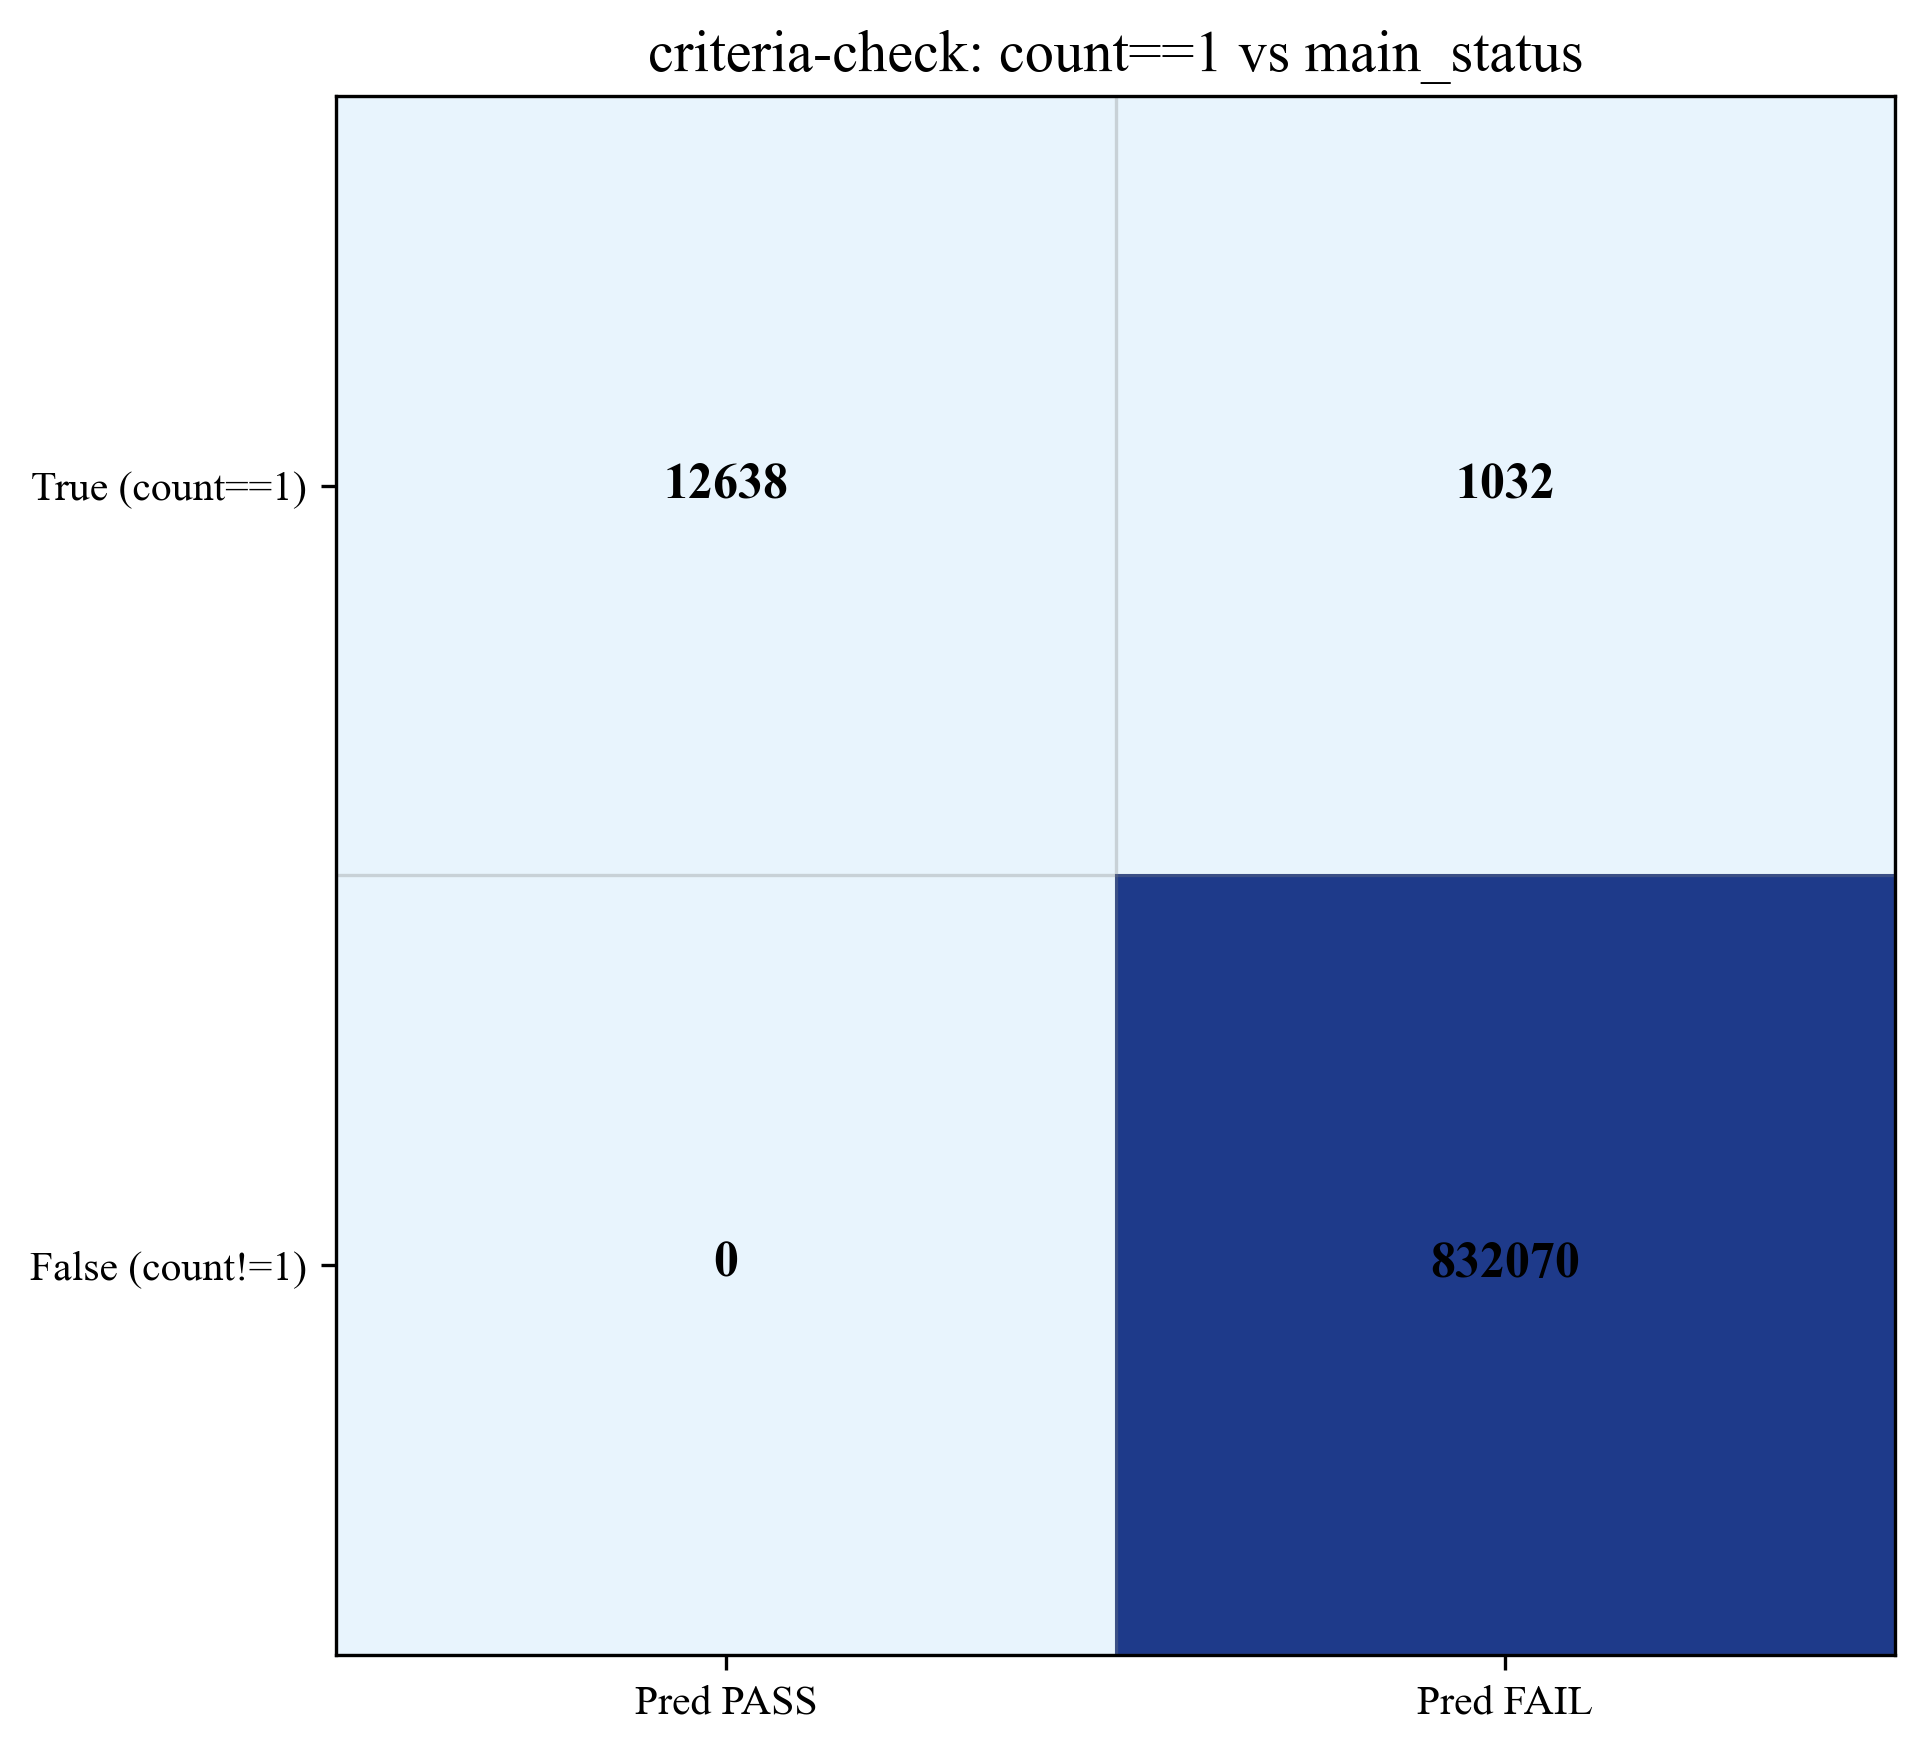

In [ ]:
import numpy as np

def compute_runtime_quantiles(runtimes):
    """Compute median, 90th, and 95th percentiles for runtime data."""
    if not runtimes:
        return {"median": None, "90th": None, "95th": None, "count": 0}
    
    runtimes_array = np.array(runtimes)
    return {
        "median": np.median(runtimes_array),
        "90th": np.percentile(runtimes_array, 90),
        "95th": np.percentile(runtimes_array, 95),
        "count": len(runtimes_array)
    }

if __name__ == "__main__":
    # Input path
    inpath = input("Inpath: ") # Should be ../results/crteria_check
    
    # Run detailed analysis
    true_counts, false_counts, fail_types, fn_failure_stages, fn_lt_witnesses, fn_ef_witnesses, all_lt_witnesses, all_ef_witnesses, file_stats, runtime_stats = analyze_fail_distribution(inpath)
    
    # Calculate confusion matrix values
    TP = true_counts["PASS"]
    FN = true_counts["FAIL"] 
    FP = false_counts["PASS"]
    TN = false_counts["FAIL"]
    
    # Calculate rates
    total_true = TP + FN
    total_false = FP + TN
    total = TP + FP + TN + FN
    
    fn_rate = FN / total_true if total_true > 0 else 0
    fp_rate = FP / total_false if total_false > 0 else 0
    accuracy = (TP + TN) / total if total > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / total_true if total_true > 0 else 0
    
    # Print aggregated results
    print("=== AGGREGATED RESULTS ===")
    print(f"True cases (count==1): PASS={true_counts['PASS']}, FAIL={true_counts['FAIL']}")
    print(f"False cases (count!=1): PASS={false_counts['PASS']}, FAIL={false_counts['FAIL']}")
    print()
    
    print(f"Confusion Matrix: TP={TP}, FP={FP}, TN={TN}, FN={FN}")
    print(f"Total: {total}")
    print()
    
    # Print rates
    print("=== PERFORMANCE METRICS ===")
    print(f"False Negative Rate: {fn_rate:.4f} ({fn_rate*100:.2f}%)")
    print(f"False Positive Rate: {fp_rate:.4f} ({fp_rate*100:.2f}%)")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall: {recall:.4f} ({recall*100:.2f}%)")
    print()
    
    # Runtime quantiles analysis
    print("=== RUNTIME QUANTILES ===")
    categories = {
        "all curves": runtime_stats["all"],
        "CERTIFIED (PASS)": runtime_stats["CERTIFIED"],
        "LT_FAIL (LT executed only)": runtime_stats["LT_FAIL"],
        "EF_FAIL (LT + partial EF executed)": runtime_stats["EF_FAIL"]
    }
    
    for category_name, runtimes in categories.items():
        quantiles = compute_runtime_quantiles(runtimes)
        print(f"{category_name}:")
        print(f"  Count: {quantiles['count']}")
        if quantiles['median'] is not None:
            print(f"  Median: {quantiles['median']:.3f}s")
            print(f"  90th percentile: {quantiles['90th']:.3f}s")
            print(f"  95th percentile: {quantiles['95th']:.3f}s")
        else:
            print(f"  No runtime data available")
        print()
    
    # Detailed failure distribution for ALL FAIL predictions
    print("=== ALL FAIL PREDICTIONS BREAKDOWN ===")
    total_pass = true_counts["PASS"] + false_counts["PASS"]
    total_fail = true_counts["FAIL"] + false_counts["FAIL"]
    print(f"PASS/FAIL totals: PASS={total_pass}, FAIL={total_fail}")
    print(f"PASS percentage: {total_pass/total*100:.2f}%, FAIL percentage: {total_fail/total*100:.2f}%")
    print()
    
    print(f"Total FAIL predictions: {fail_types['TOTAL_FAIL']}")
    if fail_types["TOTAL_FAIL"] > 0:
        lt_percent = fail_types['LT']/fail_types['TOTAL_FAIL']*100
        ef_percent = fail_types['EF']/fail_types['TOTAL_FAIL']*100
        error_percent = fail_types['ERROR']/fail_types['TOTAL_FAIL']*100
        print(f"  LT failures: {fail_types['LT']} ({lt_percent:.1f}%)")
        print(f"  EF failures: {fail_types['EF']} ({ef_percent:.1f}%)")
        print(f"  ERROR failures: {fail_types['ERROR']} ({error_percent:.1f}%)")
    print()
    
    # ALL FAIL witness frequency
    print("=== ALL FAIL WITNESS FREQUENCY ===")
    if all_lt_witnesses:
        print(f"  LT failure witnesses (total {sum(data['count'] for data in all_lt_witnesses.values())}):")
        for witness, data in sorted(all_lt_witnesses.items(), key=lambda x: x[1]["count"], reverse=True):
            count = data["count"]
            m0_values = sorted(data["m0_values"])
            print(f"    {witness}: {count} cases")
            print(f"      m0 values: {m0_values}")
        print()
    
    if all_ef_witnesses:
        print(f"  EF failure witnesses (total {sum(data['count'] for data in all_ef_witnesses.values())}):")
        for witness, data in sorted(all_ef_witnesses.items(), key=lambda x: x[1]["count"], reverse=True):
            count = data["count"]
            m0_values = sorted(data["m0_values"])
            print(f"    {witness}: {count} cases")
            print(f"      m0 values: {m0_values}")
        print()
    
    # False negative analysis (count==1 but predicted FAIL)
    print("=== FALSE NEGATIVE ANALYSIS ===")
    print(f"False negatives (FN): {FN}")
    print(f"False Negative Rate: {fn_rate:.4f} ({fn_rate*100:.2f}%)")
    if FN > 0:
        print("  False negative breakdown by failure stage:")
        print(f"    LT failures: {fn_failure_stages['LT']} ({fn_failure_stages['LT']/FN*100:.1f}% of FN)")
        print(f"    EF failures: {fn_failure_stages['EF']} ({fn_failure_stages['EF']/FN*100:.1f}% of FN)")
        print(f"    ERROR failures: {fn_failure_stages['ERROR']} ({fn_failure_stages['ERROR']/FN*100:.1f}% of FN)")
        print()
        
        # Show aggregated witness counts with m0 values for false negatives
        print("  === FALSE NEGATIVE WITNESS AGGREGATION ===")
        if fn_lt_witnesses:
            print(f"    LT failure witnesses:")
            for witness, data in sorted(fn_lt_witnesses.items(), key=lambda x: x[1]["count"], reverse=True):
                count = data["count"]
                m0_values = sorted(data["m0_values"])
                print(f"      {witness}: {count} cases ({count/fn_failure_stages['LT']*100:.1f}% of LT FN)")
                print(f"        m0 values: {m0_values}")
            print()
        
        if fn_ef_witnesses:
            print(f"    EF failure witnesses:")
            for witness, data in sorted(fn_ef_witnesses.items(), key=lambda x: x[1]["count"], reverse=True):
                count = data["count"]
                m0_values = sorted(data["m0_values"])
                print(f"      {witness}: {count} cases ({count/fn_failure_stages['EF']*100:.1f}% of EF FN)")
                print(f"        m0 values: {m0_values}")
        print()
    
    # Per-file statistics (I(E) adelic index analysis) - sorted numerically
    print("=== PER-FILE STATISTICS (I(E) ADELIC INDEX) ===")
    
    # Extract numbers and sort by numerical value
    file_entries = []
    for filename, stats in file_stats.items():
        import re
        match = re.search(r'count(\d+)', filename)
        if match:
            ie_number = int(match.group(1))
        else:
            # Fallback: try to extract any number from filename
            match = re.search(r'\d+', filename)
            ie_number = int(match.group(1)) if match else 0
        
        file_entries.append((ie_number, filename, stats))
    
    # Sort by numerical I(E) value
    file_entries.sort(key=lambda x: x[0])
    
    for ie_number, filename, stats in file_entries:
        print(f"\nI(E)={ie_number}")
        print(f"  Total curves: {stats['total_curves']}")
        print(f"  TP (count==1, PASS): {stats['TP']}")
        print(f"  FN (count==1, FAIL): {stats['FN']}")
        print(f"  LT failures: {stats['LT_fail']}")
        print(f"  EF failures: {stats['EF_fail']}")
        
        # File-level witness analysis
        if stats['lt_witnesses']:
            print(f"  LT witnesses:")
            for witness, data in sorted(stats['lt_witnesses'].items(), key=lambda x: x[1]["count"], reverse=True):
                count = data["count"]
                m0_values = sorted(data["m0_values"])
                print(f"    {witness}: {count} cases")
                print(f"      m0 values: {m0_values}")
        
        if stats['ef_witnesses']:
            print(f"  EF witnesses:")
            for witness, data in sorted(stats['ef_witnesses'].items(), key=lambda x: x[1]["count"], reverse=True):
                count = data["count"]
                m0_values = sorted(data["m0_values"])
                print(f"    {witness}: {count} cases")
                print(f"      m0 values: {m0_values}")
    
    # Plot confusion matrix
    fig, ax = plot_confusion_matrix(TP, FP, TN, FN, title="criteria-check: count==1 vs main_status")
    plt.show()